#Packaging Analysis - OCR Test
This notebook performs Optical Character Recognition (OCR) on a product's packaging and extracts key details such as brand name, expiry date, expected life span, expiration status, and object counts.

###Steps Covered:
* OCR Setup: The notebook uses an OCR tool to analyze the packaging and
extract relevant text.
*Data Parsing: The extracted text is processed to retrieve specific pieces of information, such as the brand name, expiry date, and additional metadata.
*Analysis Results: The notebook presents a structured output based on the OCR analysis.

Requirements : CUDA/Any form of GPU like NVIDIA JETSON TX1

In [ ]:
!python -m pip install git+https://github.com/huggingface/transformers

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-mi59s9yk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-mi59s9yk
  Resolved https://github.com/huggingface/transformers to commit 5fcf6286bff90a2ba3b7a4b45fdf8542ea404dbe
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 72.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10191285 sha256=b6397723089d850534022bd480c5b0905ff9c99be5a3c0fab73f5d494a65a837
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ljk_hp1/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully 

In [1]:
!pip install pillow

Saving img_03.jpg to img_03 (1).jpg


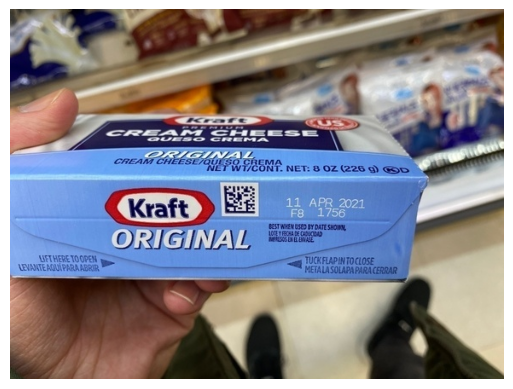

In [5]:
from google.colab import files
from PIL import Image
import io
import matplotlib.pyplot as plt

# Upload the image
uploaded = files.upload()

# Open the uploaded image
image_path = next(iter(uploaded))  # Get the file name of the uploaded image
image = Image.open(io.BytesIO(uploaded[image_path]))

# Display the image inline
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()


In [ ]:

from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from PIL import Image
from datetime import datetime
import re

# Load the model and processor
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype="auto",
    device_map="auto",
)

processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct"
)

# Load the image
image = Image.open("/content/img_03.jpg")

# Define the user message
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "Extract brand name, expiry date, expired status, expected life span in days, and object counts."
            }
        ]
    }
]

# Create a text prompt with the updated task
text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

# Process both the text and image inputs
inputs = processor(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt"
)

# Move inputs to CUDA
inputs = inputs.to("cuda")

# Generate output text
output_ids = model.generate(**inputs, max_new_tokens=1024)

# Extract generated IDs after the input sequence
generated_ids = [
    output_ids[len(input_ids):]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]

# Decode the generated output text
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)

# Print the entire output text for debugging
print(f"Generated Text: {output_text[0]}")

# Adjusted regex patterns for various expiry date formats
date_patterns = [
    r'\b(\d{2}/\d{2}/\d{4})\b',  # MM/DD/YYYY
    r'\b(\d{2}-\d{2}-\d{4})\b',  # MM-DD-YYYY
    r'\b(\d{2}/\d{2}/\d{2})\b',  # MM/DD/YY
    r'\b(\d{2}-\d{2}-\d{2})\b',  # MM-DD-YY
    r'\b(\d{2} \w+ \d{4})\b',    # DD Month YYYY (e.g., 12 May 2024)
    r'\b(\d{2} \d{2} \d{4})\b'   # DD MM YYYY (e.g., 23 10 2021)
]

# Extract expiry date
expiry_date = None
for pattern in date_patterns:
    match = re.findall(pattern, output_text[0])
    if match:
        expiry_date = match[0]
        break

# Extract brand name (using simple keyword search or regex, depending on model output)
brand_name = None
brand_patterns = [
    r"brand[\s:]*([A-Za-z0-9\s]+)",  # Look for a 'brand' keyword followed by a name
    r"([A-Za-z]+)[\s]+brand"  # Assume a word before the keyword 'brand' might be the brand name
]
for pattern in brand_patterns:
    match = re.findall(pattern, output_text[0])
    if match:
        brand_name = match[0]
        break

# Determine if the product is expired
expired = None
if expiry_date:
    try:
        # Handle various date formats for validation
        if " " in expiry_date:
            expiry_date = datetime.strptime(expiry_date, "%d %m %Y")
        elif "/" in expiry_date or "-" in expiry_date:
            expiry_date = datetime.strptime(expiry_date, "%d/%m/%Y")

        current_date = datetime.now()

        # Check if expired
        if expiry_date < current_date:
            expired = True
        else:
            expired = False
    except ValueError:
        print(f"Could not parse the expiry date format: {expiry_date}")

# Calculate expected life span if not expired
life_span_days = None
if not expired and expiry_date:
    life_span_days = (expiry_date - current_date).days

# Object count extraction (simple keyword search)
object_count = None
count_pattern = r"(\d+)\s*objects?|(\d+)\s*items?"
count_match = re.findall(count_pattern, output_text[0])
if count_match:
    object_count = int(count_match[0][0])  # Taking the first match group

# Display results
print(f"Brand Name: {brand_name}")
print(f"Expiry Date: {expiry_date.strftime('%d/%m/%Y') if expiry_date else 'Not found'}")
print(f"Expired: {'Yes' if expired else 'No'}")
print(f"Expected Life Span in Days: {life_span_days if life_span_days is not None else 'N/A'}")
print(f"Object Count: {object_count if object_count is not None else 'Not found'}")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Generated Text: The image shows a hand holding a box of Kraft Original Cream Cheese. Here are the details:

- **Brand Name**: Kraft
- **Expiry Date**: 11 April 2021
- **Expected Life Span in Days**: 1756
- **Expiration Status**: Best Before Use By Date Shown
- **Object Counts**: 1 (box of cream cheese)

The box also includes the following information:

- **Net Weight**: 8 oz (226 g)
- **Net Contents**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226 g)
- **Net Weight/Content**: 8 oz (226

NameError: name 'current_date' is not defined

---
# Fruit Freshness Analysis

This project aims to detect the freshness of fruits in images using a customized YOLO (You Only Look Once) object detection model : best.pt. The model identifies and classifies objects (e.g., fresh or rotten fruits) based on their visual characteristics and outputs a detection table with counts for each class.

note : this model does not require a CUDA/GPU and can be run on the CPU alone

In [7]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 19.3 MB/s eta 0:00:00


Saving images (3).jpg to images (3).jpg

image 1/1 /content/images (3).jpg: 256x640 1 fresh banana, 5 rotten bananas, 42.2ms
Speed: 1.1ms preprocess, 42.2ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 640)


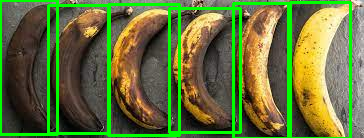

Object Counts:
rotten banana: 5
fresh banana: 1
Freshness Detection Table:
   Sl no    Class Label  Count
0      1  rotten banana      5
1      2   fresh banana      1


In [20]:
import torch
import cv2
from collections import Counter
from PIL import Image
import numpy as np
import pandas as pd
from datetime import datetime
from google.colab import files
import io
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow  # Import cv2_imshow instead of cv2.imshow


# Freshness Detection (YOLO Model)
from ultralytics import YOLO

# Load YOLO model for freshness detection
def load_freshness_model():
    return YOLO("/content/best.pt")  # Path to YOLO model (update as necessary)

model_freshness = load_freshness_model()

# Process image for freshness detection
def process_and_display_image(image_path):
    results = model_freshness.predict(source=image_path, conf=0.3, imgsz=640)
    image = cv2.imread(image_path)
    counts = Counter()

    for result in results:
        for box in result.boxes.data.tolist():
            x1, y1, x2, y2, confidence, class_id = box
            class_name = model_freshness.names[int(class_id)]
            counts[class_name] += 1
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            label = f"{class_name} {confidence:.2f}"
            cv2.putText(image, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display processed image using cv2_imshow
    cv2_imshow(image)

    # Display object counts
    print("Object Counts:")
    for class_name, count in counts.items():
        print(f"{class_name}: {count}")

    # Initialize freshness products list
    freshness_products = []

    # Update freshness products list
    for class_name, count in counts.items():
        found = False
        for freshness_product in freshness_products:
            if freshness_product['Class Label'] == class_name:
                freshness_product['Count'] += count
                found = True
                break

        if not found:
            freshness_products.append({
                "Sl no": len(freshness_products) + 1,
                "Class Label": class_name,
                "Count": count
            })

    # Show freshness products table
    df_freshness = pd.DataFrame(freshness_products)
    print("Freshness Detection Table:")
    print(df_freshness)

# Upload image for freshness detection
uploaded_freshness = files.upload()
image_path_freshness = next(iter(uploaded_freshness))  # Get the file name of the uploaded image
image_freshness = image_path_freshness

# Process and display freshness detection results
process_and_display_image(image_freshness)
